In [1]:
# 计算样本熵的包
from sampen import sampen2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# 读取数据
df = pd.read_excel('/Users/tiancaixiaohuoban/Desktop/实习/买方实习/中信建投期货（金融工程）/研报复现/东证期货/择时策略/上证综合指数.xlsx', index_col='date', parse_dates=True)
df.head()

,Close
date,
1990-12-19,100.00
1990-12-20,104.39
1990-12-21,109.13
1990-12-24,114.55
1990-12-25,120.25


In [4]:
#计算短周期的moving average
#计算长周期的moving average

short_term =13
long_term = 33

df['SMA1'] = df.Close.rolling(short_term).mean()
df['SMA2'] = df.Close.rolling(long_term).mean() 
df

,Close,SMA1,SMA2
date,,,
1990-12-19,100.0000,NaN,NaN
1990-12-20,104.3900,NaN,NaN
1990-12-21,109.1300,NaN,NaN
1990-12-24,114.5500,NaN,NaN
1990-12-25,120.2500,NaN,NaN
...,...,...,...
2023-01-18,3224.4060,3168.043646,3148.763564
2023-01-19,3240.2794,3179.660685,3151.313115
2023-01-20,3264.8138,3191.068523,3152.919158


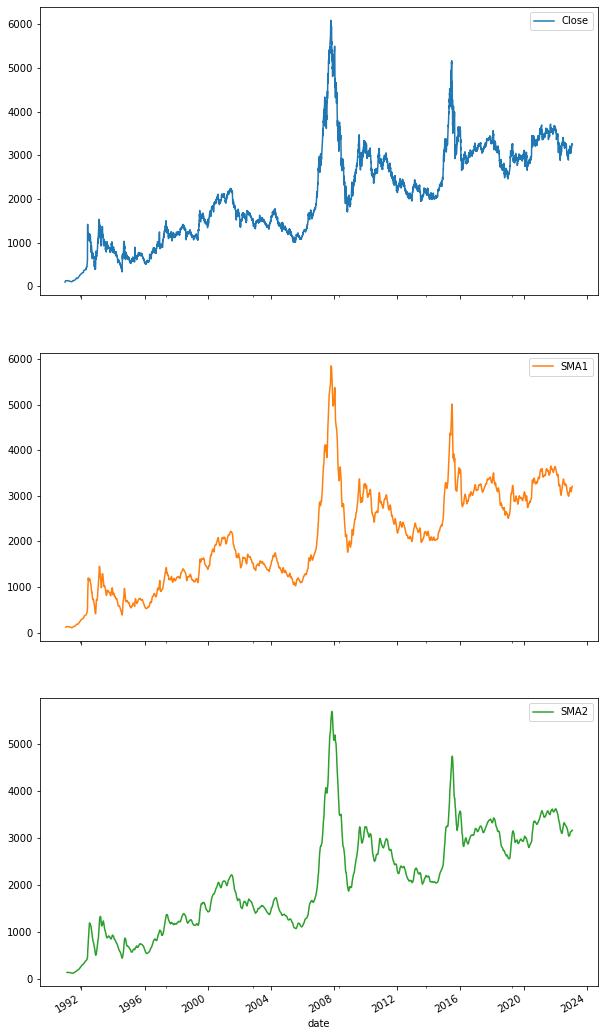

In [5]:
#数据可视化
plots = df.plot(subplots=True, figsize=(10, 20))
plt.show()

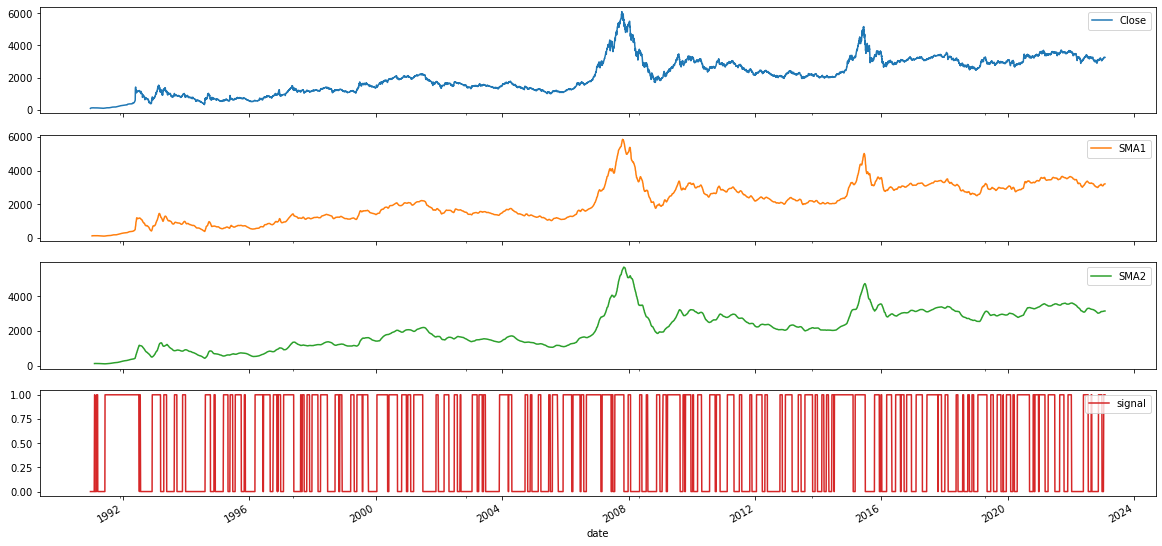

In [6]:
# 构造基础交易信号，数据可视化
# 当长期均线低于短期均线时，标记为潜在进场时机，即1.0，否则为0
df['signal'] = np.where(df['SMA1'] > df['SMA2'], 1.0, 0.0)
plots = df[['Close', 'SMA1', 'SMA2', "signal"]].plot(subplots=True, figsize=(20, 10))
plt.show()

In [7]:
# 实例
# signal = df['Signal'].tolist()
# sampen = sampen2(signal)

In [8]:
# 提取m=1的entropy值
# print(sampen[1][1])

In [9]:
def sample_entropy(time_series):
    signal = time_series.tolist()
    
    # 计算样本熵
    try:
        sampen_result = sampen2(signal)
        return sampen_result[1][1]
    except ZeroDivisionError:
        # 处理分母为零的情况，可以返回默认值或采取其他适当的处理方式
        return 0.0

In [10]:
# 定义择时策略函数
def timing_strategy(data, threshold, slope_window1, slope_window2, ma_windows):
    # 计算上证指数的样本熵序列
    data['SampleEntropy'] = data['Close'].rolling(window=144).apply(lambda x: sample_entropy(x))

    # 计算样本熵序列的斜率
    data['EntropySlope1'] = data['SampleEntropy'].diff(slope_window1)
    data['EntropySlope2'] = data['SampleEntropy'].diff(slope_window2)

    # 计算均线
    for ma_window in ma_windows:
        data[f'MA_{ma_window}'] = data['SampleEntropy'].rolling(window=ma_window).mean()

    data = data.dropna()

    # 设定择时规则1，斜率参数55
    data.loc[(data['SampleEntropy'] < -threshold), 'signal'] = 0  # 潜在卖出信号
    data.loc[(data['SampleEntropy'] > threshold), 'signal'] = 1  # 潜在买入信号
    
    return data

In [11]:
threshold = 0.2 #研报里面选择的阈值设定
slope_window1 = 55  # 样本熵序列的斜率参数1
slope_window2 = 89  # 样本熵序列的斜率参数2
ma_windows = [5, 10, 20, 30, 40, 50]  # 行情序列的均线参数

In [12]:
# 执行择时策略
result = timing_strategy(df, threshold, slope_window1, slope_window2, ma_windows)

/Users/tiancaixiaohuoban/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-10-9b45ed811a3d>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[(data['SampleEntropy'] < -threshold), 'signal'] = 0  # 潜在卖出信号
/Users/tiancaixiaohuoban/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

In [13]:
result['signal'].describe()

count    7612.000000
mean        0.565029
std         0.495786
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: signal, dtype: float64

In [14]:
for i in range(1,len(result)):
    row_index = result.index[i]
    row_index_last = result.index[i-1]
#     # 样本熵标记变盘点，55
#     # 样本熵出现下降趋势，且长期均线居于短期均线之下，市场行情明朗，且有上行趋势，说明应该买入
#     if (result.loc[row_index,'EntropySlope1'] <= 0) and (result.loc[row_index_last,'signal'] == 1):
#          result.loc[row_index,'Signal'] = 1
#     # 样本熵出现上升趋势，且长期均线居于短期均线之上，市场行情复杂，且有下行趋势，说明应该卖出
#     if (result.loc[row_index,'EntropySlope1'] > 0) and (result.loc[row_index_last,'signal'] == 0):
#          result.loc[row_index,'Signal'] = -1
    # 样本熵标记变盘点，89
    # 样本熵出现下降趋势，且长期均线居于短期均线之下，市场行情明朗，且有上行趋势，说明应该买入
    if (result.loc[row_index,'EntropySlope2'] <= 0) and (result.loc[row_index_last,'signal'] == 1):
         result.loc[row_index,'Signal'] = 1
    # 样本熵出现上升趋势，且长期均线居于短期均线之上，市场行情复杂，且有下行趋势，说明应该卖出
    if (result.loc[row_index,'EntropySlope2'] > 0) and (result.loc[row_index_last,'signal'] == 0):
         result.loc[row_index,'Signal'] = -1
    #普通的双均线策略   
#     if (result.loc[row_index,'signal'] ==0) and (result.loc[row_index_last,'signal'] ==0):
#         result.loc[row_index,'Signal'] = 0
#     if (result.loc[row_index,'signal'] ==1) and (result.loc[row_index_last,'signal'] ==1):
#         result.loc[row_index,'Signal'] = 0

#     if (result.loc[row_index,'signal'] ==1) and (result.loc[row_index_last,'signal'] ==0):
#         result.loc[row_index,'Signal'] = 1
#     if (result.loc[row_index,'signal'] ==0) and (result.loc[row_index_last,'signal'] ==1):
#         result.loc[row_index,'Signal'] = -1
        
# 根据布林带条件产生买入和卖出信号
# df.loc[df['Close'] > df['upper_band'], 'Signal'] = 1  # 价格高于布林带上轨，产生买入信号
# df.loc[df['Close'] < df['lower_band'], 'Signal'] = -1  # 价格低于布林带下轨，产生卖出信号

/Users/tiancaixiaohuoban/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/tiancaixiaohuoban/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1601: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(new_indexer, value)
<ipython-input-14-2ff5ddd07e6f>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

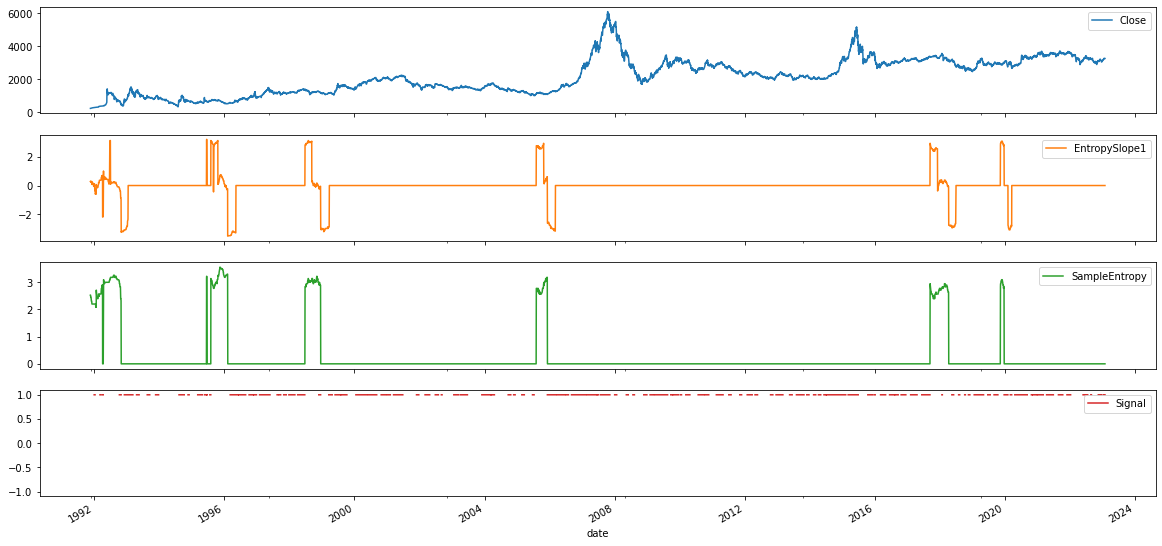

In [15]:
plots = result[['Close', 'EntropySlope1', 'SampleEntropy', "Signal"]].plot(subplots=True, figsize=(20, 10))
plt.show()

In [16]:
def visualize_trades(data):
    # Create a figure and axis
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Plot Cumulative Profit on the first y-axis
    ax1.plot(result.index, data['CumulativeProfit'], label='Cumulative Profit', color='blue')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Cumulative Profit', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    
    # Create a second y-axis for Close Price
    ax2 = ax1.twinx()
    ax2.plot(result.index, data['Close'], label='Close Price', color='orange')
    ax2.set_ylabel('Close Price', color='orange')
    ax2.tick_params(axis='y', labelcolor='orange')

    # Set title
    plt.title('Close Price and Cumulative Profit')

    # Display legend
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='upper left')

    # Show the plot
    plt.show()

In [17]:
def backtest_strategy(data):
    # 回测函数
    capital = 10000  # 初始本金
    data.loc[:, 'Position'] = data['Signal'].fillna(0)  # 根据Signal列得到仓位变化
    max_drawdown = 0  # 最大回撤
    max_profit = 0  # 最大盈利
    cumulative_profit = 0  # 累计盈亏
    start_capital = capital  # 记录起始本金
    trade_records = []  # 交易记录
    total_trades = 0  # 总交易次数
    winning_trades = 0  # 赢利交易次数
    
    # 累计盈亏列表
    cumulative_profit_list = []

    # 遍历每个交易日
    for i in range(1, len(data)):
        # 计算当日市值
        total_value = capital + data['Position'].iloc[i] * data['Close'].iloc[i]

        # 更新最大盈利
        max_profit = max(max_profit, total_value - start_capital)

        # 计算当日盈亏
        daily_profit = total_value - start_capital

        # 更新累计盈亏
        cumulative_profit += daily_profit
        
        # 记录每一天的累计盈亏
        cumulative_profit_list.append(cumulative_profit)

        # 计算最大回撤
        drawdown = (total_value - start_capital) / start_capital
        max_drawdown = min(max_drawdown, drawdown)

        # 打印交易记录
        if data['Position'].iloc[i] != 0:
            total_trades += 1
            if daily_profit > 0:
                winning_trades += 1

            trade_records.append({
                'Date': data.index[i],
                'Action': 'Buy' if data['Position'].iloc[i] == 1 else 'Sell',
                'Price': data['Close'].iloc[i],
                'Position': data['Position'].iloc[i],
                'TotalValue': total_value,
                'CumulativeProfit': cumulative_profit,
                'Drawdown': drawdown
            })

            # 处理卖出信号
            if data['Position'].iloc[i] == -1:
                capital += data['Close'].iloc[i]  # 减少仓位，这里假设卖出后将资金加到本金中

    # 计算年化收益率
    end_date = data.index[-1]
    years = (end_date - data.index[0]).days / 365.25
    annualized_return = (cumulative_profit / start_capital) ** (1 / years) - 1

    # 计算胜率
    if total_trades > 0:
        win_rate = winning_trades / total_trades
    else:
        win_rate = 0.0
    
    # 将累计盈亏列表添加到数据框中
    data['CumulativeProfit'] = [0] + cumulative_profit_list  # 添加一个初始值0

    # 打印统计信息
    print(f"最大回撤: {max_drawdown:.2%}")
    print(f"最大盈利: {max_profit:.2f}")
    print(f"年化收益率: {annualized_return:.2%}")
    print(f"胜率: {win_rate:.2%}")
    
    # 可视化交易记录
    visualize_trades(data)

/Users/tiancaixiaohuoban/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/tiancaixiaohuoban/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1783: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value
<ipython-input-17-30b89b15ff1f>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

最大回撤: -14.02%
最大盈利: 8596.39
年化收益率: 27.86%
胜率: 99.97%


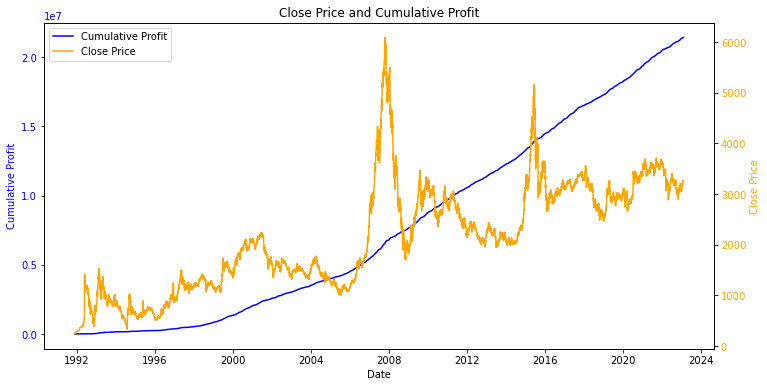

In [18]:
backtest_strategy(result)